In [1]:
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Import curve fitting package from scipy
from sklearn.linear_model import LinearRegression

# import os
import os, sys, shutil

##################################################################
# define error handler
class UnAcceptedValueError(Exception):   
    def __init__(self, data):    
        self.data = data
    def __str__(self):
        return repr(self.data)

####################################################################
# gets all items in directory
items = os.listdir(".")

# lists all .csv
csv_list = []
for names in items:
    if names.endswith(".CSV"):
        csv_list.append(names)
print(csv_list)
try:
    if(len(csv_list) > 1):
        raise UnAcceptedValueError("More than 1x .CSV file in the directory");
except UnAcceptedValueError as e:
    print ("Received error:", e.data)
    # kills the process
    quit()
##########################################################################################
#import dataset as dataframe
raw_data = pd.read_csv(csv_list[0], header=None)

date= raw_data.iloc[1,1]

data = raw_data.iloc[6:,:]
data = data.reset_index(drop=True)

calibrants = data.iloc[:24,[2]]


#  define limits for linear range of platereader
upper_limit = 0.75
lower_limit = 0.45

#######################################################################

print(os.getcwd())
path = "/home/jovyan/output/"
# make directory for sticking the output in
if os.path.isdir(path) == False:
    os.mkdir(path, mode=0o777)
    
    
# now that the dataset has been read in, move it into the output file for neatness.
if 1 == 1:
    shutil.move(csv_list[0], path)

# navigate into the directory for future plot storage
os.chdir(path)


['bradford2_opp2.CSV']
/home/jovyan


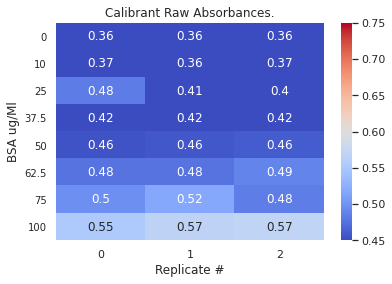

In [2]:
# reshape
calibrants = calibrants.astype(float)
calibrants_np = calibrants.to_numpy()

replicates = 3

# real concs in wells. Stocks in ug/ml diluted by 20x
calibrant_range = ["0","10","25","37.5", "50", "62.5", "75","100"]

calibrants_np_2d = np.reshape(calibrants_np, (int(len(calibrants_np)/replicates), replicates))

import seaborn as sns

sns.set()
ax1 = sns.heatmap(calibrants_np_2d, vmin = lower_limit, vmax = upper_limit, annot=True, cmap="coolwarm")
ax1.set_ylabel("BSA ug/Ml")
ax1.set_title("Calibrant Raw Absorbances.")
ax1.set_xlabel("Replicate #")
plt.yticks(np.arange(8)+0.5,calibrant_range, rotation=0, fontsize="10")

plt.savefig("BSA_absorbances_heat.png")

plt.show()

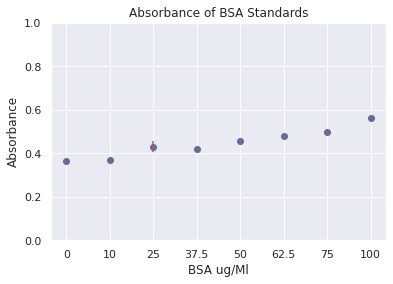

In [3]:
calibrants_df = pd.DataFrame(calibrants_np_2d, columns=["Rep1", "Rep2", "Rep3"], index=calibrant_range)

calibrants_df["Mean"] = calibrants_df.mean(axis=1)
calibrants_df["SEM"] = calibrants_df.iloc[:,:3].sem(axis=1)

calibrants_df_avg = calibrants_df[["Mean", "SEM"]]

#plot 

x = calibrants_df_avg.index
y = calibrants_df_avg['Mean']

plt.scatter(x,y)
plt.errorbar(x,y, yerr=calibrants_df_avg['SEM'], fmt="|", color="r")

plt.title("Absorbance of BSA Standards")
plt.ylabel("Absorbance")
plt.xlabel("BSA ug/Ml")
plt.ylim(0,1)
plt.savefig("BSA_Standard_Absorbances_scatter.png")
plt.show()


In [4]:
##################   Subset Standards aborbance values that fall within the linear range (0.75 - 0.45)

acceptable_calibrants = calibrants_df.loc[(calibrants_df["Mean"] >= lower_limit) & (calibrants_df["Mean"] <= upper_limit)]
print(acceptable_calibrants)

       Rep1   Rep2   Rep3      Mean       SEM
50    0.455  0.458  0.461  0.458000  0.001732
62.5  0.478  0.478  0.489  0.481667  0.003667
75    0.498  0.518  0.485  0.500333  0.009597
100   0.554  0.568  0.570  0.564000  0.005033


Index(['50', '62.5', '75', '100'], dtype='object')
[50.0, 62.5, 75.0, 100.0]
coefficient of determination: 0.9876927020583938


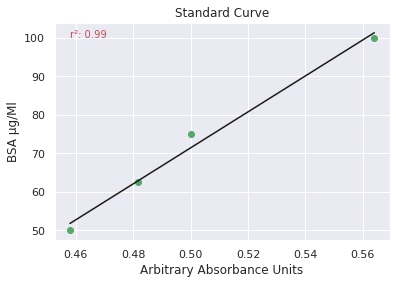

In [5]:
################# Standard Curve
acceptable_calibrant_range = acceptable_calibrants.index
print(acceptable_calibrant_range)

# calibrant concs
calibrant_range_numerical = [float(ele) for ele in acceptable_calibrant_range]
print(calibrant_range_numerical)

# fit curves
#function for looping?
model = LinearRegression()
# fitc data in to array and reverse the order
x = np.array(acceptable_calibrants["Mean"]).reshape(-1,1)

# List of nM concs into array
y = np.array(calibrant_range_numerical).reshape(-1,1)

x = x.reshape(-1,1)

# Fit
model.fit(x,y)
r_sq = model.score(x, y)
print('coefficient of determination:', r_sq)

#Plot
plt.scatter(x, y, color='g')
plt.plot(x, model.predict(x), color='k')

textstr ='r²: ' +str(round(r_sq,2))
plt.text(acceptable_calibrants["Mean"].min(), calibrant_range_numerical[-1], textstr, color='r', fontsize=10)

plt.title('Standard Curve')
plt.xlabel('Arbitrary Absorbance Units')
plt.ylabel('BSA μg/Ml')
plt.savefig("BSA_Standard_Curve.png")
plt.show()




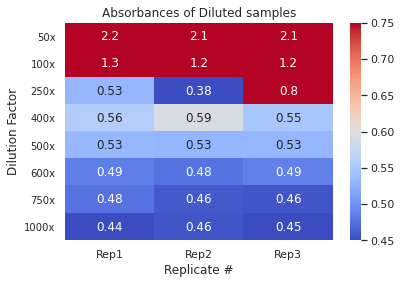

In [6]:
# samples mean & sem
sample_data = data.iloc[24:,2].astype(float)

sample_data = sample_data.values
sample_data = sample_data.reshape((int(len(sample_data)/replicates), replicates))

sample_list =["50x","100x","250x", "400x", "500x","600x","750x","1000x"]

sample_data = pd.DataFrame(sample_data, columns=["Rep1", "Rep2", "Rep3"], index = sample_list)




sns.set()


sns.heatmap(sample_data, vmin = lower_limit, vmax = upper_limit, annot=True, cmap="coolwarm")



plt.ylabel("Dilution Factor")
plt.title("Absorbances of Diluted samples")
plt.xlabel("Replicate #")
plt.yticks(np.arange(sample_data.shape[0])+0.5, sample_list, rotation=0, fontsize="10")
plt.savefig("Sample_Absorbances_heat.png")



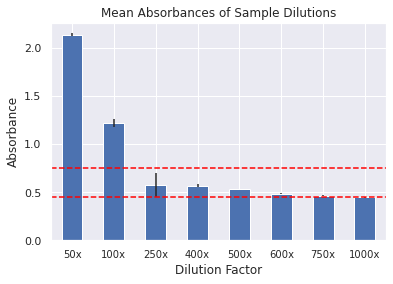

In [7]:


sample_data["Mean"] = sample_data.mean(axis=1)
sample_data["SEM"] = sample_data.iloc[:,:3].sem(axis=1)


samples_df_avg = sample_data[["Mean", "SEM"]]

ax3 = samples_df_avg.plot(kind="bar", yerr="SEM", legend=False)

ax3.axhline(y = upper_limit, color='red', linestyle='--')
ax3.axhline(y = lower_limit, color='red', linestyle='--')

ax3.set_title("Mean Absorbances of Sample Dilutions")
ax3.set_ylabel("Absorbance")
ax3.set_xlabel("Dilution Factor")
plt.xticks(np.arange(samples_df_avg.shape[0]),sample_list, rotation=0, fontsize="10")
plt.savefig("Sample_Absorbances_Bar.png")

In [8]:
#### subset samples that don't fall in linear range
acceptable_samples = sample_data.loc[(sample_data["Mean"] >= lower_limit) & (sample_data["Mean"] <= upper_limit)]

###### exclude samples where the SEM is greater than 0.01
acceptable_samples = acceptable_samples.loc[(acceptable_samples["SEM"] <= 0.01)]

#get the index again for the names
acceptable_samples_list = acceptable_samples.index
print(acceptable_samples)

       Rep1   Rep2   Rep3      Mean       SEM
500x  0.534  0.531  0.533  0.532667  0.000882
600x  0.486  0.478  0.487  0.483667  0.002848
750x  0.476  0.460  0.457  0.464333  0.005897


In [9]:
# convert samples
predicted_ug_per_ml = model.predict(np.array(acceptable_samples.iloc[:,:3]).reshape(-1,1))
predicted_ug_per_ml = np.reshape(predicted_ug_per_ml,(int(len(predicted_ug_per_ml)/replicates), replicates))
predicted_ug_per_ml = pd.DataFrame(predicted_ug_per_ml, columns=["Rep1", "Rep2", "Rep3"], index = acceptable_samples_list)



In [10]:
#account for the dilutions
numrows = predicted_ug_per_ml.shape[0]

print("Raw dataset:")
print(predicted_ug_per_ml)
print(" ")

for index, row in predicted_ug_per_ml.iterrows():
    # get the dilution factor from the index
    ind = str(index)
    ind = ind[:-1]
    ind = int(ind)

    print("Multiplying row " + str(index) +  " by dilution factor: "+ str(ind))
    
    predicted_ug_per_ml.loc[index, "Rep1"] = predicted_ug_per_ml.loc[index, "Rep1"]*ind
    predicted_ug_per_ml.loc[index, "Rep2"] = predicted_ug_per_ml.loc[index, "Rep2"]*ind
    predicted_ug_per_ml.loc[index, "Rep3"] = predicted_ug_per_ml.loc[index, "Rep3"]*ind

# get list of row indexes

print(" ")
print("dataset multipled by dilution factor")
print(" ")


print(predicted_ug_per_ml)

# Use that to perform that calculations just on the right columns
# recalculate mean and SEM

predicted_ug_per_ml['ug/ml'] = predicted_ug_per_ml.loc[list(predicted_ug_per_ml.index),["Rep1", "Rep2","Rep3"]].mean(axis=1)
predicted_ug_per_ml['ug/ml SEM'] = predicted_ug_per_ml.loc[list(predicted_ug_per_ml.index),["Rep1", "Rep2","Rep3"]].sem(axis=1)

print(" ")
print("dataset in ug/ml")
print(" ")

print(predicted_ug_per_ml[['ug/ml','ug/ml SEM']])


Raw dataset:
           Rep1       Rep2       Rep3
500x  87.285461  85.884510  86.818477
600x  64.870245  61.134376  65.337229
750x  60.200408  52.728669  51.327718
 
Multiplying row 500x by dilution factor: 500
Multiplying row 600x by dilution factor: 600
Multiplying row 750x by dilution factor: 750
 
dataset multipled by dilution factor
 
              Rep1          Rep2          Rep3
500x  43642.730576  42942.255069  43409.238740
600x  38922.146959  36680.625336  39202.337161
750x  45150.306164  39546.502108  38495.788848
 
dataset in ug/ml
 
             ug/ml    ug/ml SEM
500x  43331.408128   205.920443
600x  38268.369819   797.982047
750x  41064.199040  2065.446131


In [11]:

#get index to use and names
predicted_ug_per_ml = predicted_ug_per_ml.reset_index()
#convert all to strings
predicted_ug_per_ml['index'] = predicted_ug_per_ml['index'].astype(str)
print(predicted_ug_per_ml)



  index          Rep1          Rep2          Rep3         ug/ml    ug/ml SEM
0  500x  43642.730576  42942.255069  43409.238740  43331.408128   205.920443
1  600x  38922.146959  36680.625336  39202.337161  38268.369819   797.982047
2  750x  45150.306164  39546.502108  38495.788848  41064.199040  2065.446131


In [12]:
######################### convert ug/ml to mg/ml
# grab the raw values
predicted_mg_per_ml = predicted_ug_per_ml[['Rep1','Rep2','Rep3']]
# convert
predicted_mg_per_ml = predicted_mg_per_ml/1000
# append index
predicted_mg_per_ml['index'] = predicted_ug_per_ml['index']


print(predicted_mg_per_ml)

        Rep1       Rep2       Rep3 index
0  43.642731  42.942255  43.409239  500x
1  38.922147  36.680625  39.202337  600x
2  45.150306  39.546502  38.495789  750x


In [13]:
####################### generate means and stats
predicted_mg_per_ml['mg/ml'] = predicted_mg_per_ml.loc[list(predicted_mg_per_ml.index),["Rep1", "Rep2","Rep3"]].mean(axis=1)
predicted_mg_per_ml['mg/ml SEM'] = predicted_mg_per_ml.loc[list(predicted_mg_per_ml.index),["Rep1", "Rep2","Rep3"]].sem(axis=1)

print(predicted_mg_per_ml)

        Rep1       Rep2       Rep3 index      mg/ml  mg/ml SEM
0  43.642731  42.942255  43.409239  500x  43.331408   0.205920
1  38.922147  36.680625  39.202337  600x  38.268370   0.797982
2  45.150306  39.546502  38.495789  750x  41.064199   2.065446


       mg/ml  mg/ml SEM
0  43.331408   0.205920
1  38.268370   0.797982
2  41.064199   2.065446


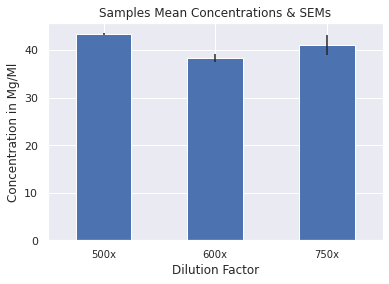

In [14]:


samples_bar_av_df = predicted_mg_per_ml[["mg/ml", "mg/ml SEM"]]
print(samples_bar_av_df)

ax4 = samples_bar_av_df.plot(kind="bar", yerr="mg/ml SEM", legend=False)
ax4.set_title("Samples Mean Concentrations & SEMs")
ax4.set_ylabel("Concentration in Mg/Ml")
ax4.set_xlabel("Dilution Factor")
plt.xticks(np.arange(samples_bar_av_df.shape[0]),acceptable_samples_list, rotation=0, fontsize="10")
plt.savefig("Conc_bar.png")




In [15]:
############### check is the SEM on the mean of means is too large.


#grab all of the replicates
checker_set_df = predicted_mg_per_ml[['Rep1', 'Rep2', 'Rep3']]

# initalise an empty series
checker_set_series = pd.Series(dtype='float64')

# go through the replicates and put them in the series
for name, values in checker_set_df.iteritems():
    checker_set_series = checker_set_series.append(values)

# reset the series
checker_set_series = checker_set_series.reset_index(drop=True)
print('')
#print('Compiled Replicates')
#print(checker_set_series)
print('')

# generate the mean and sem
checker_mean, checker_sem = (checker_set_series.mean(),checker_set_series.sem())

checker_mean_5_percent = checker_mean/20

print('Mean of means: ')
print(checker_mean)
print(' ')
print('SEM of means: ')
print(checker_sem)
print(' ')
print('Is the SEM greater than 5% of the Mean?:')
print(checker_sem > checker_mean_5_percent)



Mean of means: 
40.887992329086664
 
SEM of means: 
0.973700935063151
 
Is the SEM greater than 5% of the Mean?:
False


In [16]:
############## Is the sem greater than 5% of the mean?
# If so: check for outliers.
if checker_sem > checker_mean_5_percent:
    
    ####################################################################################################################
    ####################################################################################################################
    ############### Start if Greater than BlOCK
    
    print('SEM is greater and outliers MIGHT have been identified')
    
    
    #################### box plot to identify outlier
    plt.boxplot(x=predicted_mg_per_ml['mg/ml'], vert=False)
    plt.title("Box Plot of Mean Concentrations")
    plt.xlabel("Mg/Ml")

    plt.savefig("Box_plot.png")
    plt.show()
    
    
    #########################################################
    #calculate interquartile range of values in the 'points' column
    q75, q25 = np.percentile(predicted_mg_per_ml['mg/ml'], [75 ,25])
    
    print(' ')
    print('q25: '+str(q25))
    print(' ')
    print('Mean: '+str(checker_mean))
    print(' ')
    print('q75: '+str(q75))
    print(' ')    
        
    ######### retain values that are within the interquartile range
    acceptable_concs = predicted_mg_per_ml.loc[(predicted_mg_per_ml["mg/ml"] >=q25) & (predicted_mg_per_ml["mg/ml"] <=q75)]

    print('The concentrations that are retained after outlier filter')
    print(' ')
    print(acceptable_concs)
    print(' ')
    

    #########################################################
    ####   plot a bar chart of the accepted concentrations
    
    barplot_df = acceptable_concs[['index','mg/ml','mg/ml SEM']]
    ax4 = barplot_df.plot(kind="bar", yerr="mg/ml SEM", legend=False)
    ax4.set_title("Samples Mean Concentrations & SEMs")
    ax4.set_ylabel("Concentration in Mg/Ml")
    ax4.set_xlabel("Dilution Factor")
    plt.xticks(np.arange(acceptable_concs.shape[0]),acceptable_concs['index'], rotation=0, fontsize="10")
    plt.savefig("Best_concs_bar.png")
    
    #############################################################
    ##### using the accepted concentrations to generate a consensus concentration and export it.

    subsetted = acceptable_concs[['Rep1', 'Rep2', 'Rep3']]

    compiled = pd.Series(dtype='float64')

    for name, values in subsetted.iteritems():
        compiled = compiled.append(values)

    compiled = compiled.reset_index(drop=True)
    print('')
    print('Compiled Replicates')
    print(compiled)
    print('')
    consensus_mean, consensus_sem = (compiled.mean(),compiled.sem())
    print('Generated Consensus Concentration:')
    print('consensus_mean: '+ str(consensus_mean))
    print('consensus_sem: ' + str(consensus_sem))
    consensus_num_samples = acceptable_concs.shape[0]
    print('Generated from # dilutions: ' + str(consensus_num_samples))
    
    print(' ')
    print('Saving to Consensus_concentration.csv ...')
    consensus_printout = pd.DataFrame(data = [[consensus_mean, consensus_sem, consensus_num_samples]], columns=['Consensus_Mean','Consensus_Sem','Calculated_From_#_Dilutions'])
    consensus_printout.to_csv('Consensus_concentration.csv')
    
    ############## END OF IF Greater than BLOCK
    ###################################################################################################################################
    ###################################################################################################################################

else:
    
    ####################################################################################################################################
    ####################################################################################################################################
    ############# Start of IF not Greater BLOCK
    
    print('SEM is not greater and no outliers have been identified')
    
    subsetted = predicted_mg_per_ml[['Rep1', 'Rep2', 'Rep3']]

    compiled = pd.Series(dtype='float64')

    for name, values in subsetted.iteritems():
        compiled = compiled.append(values)

    compiled = compiled.reset_index(drop=True)
    print('')
    print('Compiled Replicates')
    print(compiled)
    print('')
    consensus_mean, consensus_sem = (compiled.mean(),compiled.sem())
    print('Generated Consensus Concentration:')
    print('consensus_mean: '+ str(consensus_mean))
    print('consensus_sem: ' + str(consensus_sem))
    consensus_num_samples = predicted_mg_per_ml.shape[0]
    print('Generated from # dilutions: ' + str(consensus_num_samples))
    
    print(' ')
    print('Saving to Consensus_concentration.csv ...')
    consensus_printout = pd.DataFrame(data = [[consensus_mean, consensus_sem, consensus_num_samples]], columns=['Consensus_Mean','Consensus_Sem','Calculated_From_#_Dilutions'])
    consensus_printout.to_csv('Consensus_concentration.csv')


    

SEM is not greater and no outliers have been identified

Compiled Replicates
0    43.642731
1    38.922147
2    45.150306
3    42.942255
4    36.680625
5    39.546502
6    43.409239
7    39.202337
8    38.495789
dtype: float64

Generated Consensus Concentration:
consensus_mean: 40.887992329086664
consensus_sem: 0.973700935063151
Generated from # dilutions: 3
 
Saving to Consensus_concentration.csv ...
